In [11]:
!pip install tsai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.6 MB/s eta 0:00:00a 0:00:01


In [12]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import matplotlib.pyplot as plt
from tsai.all import *

In [13]:
class ArrayGenerator:
    import numpy as np
    
    dataset_categories = {
        1: "motor",
        2: "bearing",
        3: "flow",
        4: "lxc",
        5: "mixed",
        6: "coupling",
        7: "all",
        8: "status"
    }
    
    dataset_descriptions = {
        1: {"Faults classified": "AirGap, Electrical and SoftFoot problems", "Channels taken": "Motor channels only", "Labels array": "Binary"},
        2: {"Faults classified": "BearingFault, BearingWear, BearingLubrication", "Channels taken": "According to label", "Labels array": "Binary"},
        3: {"Faults classified": "Flow problem", "Channels taken": "Machine channels only", "Labels array": "Binary"},
        4: {"Faults classified": "LXC, XC, Losseness", "Channels taken": "All", "Labels array": "Binary"},
        5: {"Faults classified": "LXC, Unbalance, BaseProblems", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        6: {"Faults classified": "Coupling problems", "Channels taken": "Drive end channels only", "Labels array": "Binary"},
        7: {"Faults classified": "All", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        8: {"Faults classified": "Status", "Channels taken": "All", "Labels array": "multiclass"}
    }
    
    def separate_data(self, ts, labels, split_method):
        _, num_channels, num_points = ts.shape
        
        if split_method == "channel":
            new_ts = ts.reshape(-1, 1, num_points)
            new_labels = np.repeat(labels, repeats=num_channels, axis=0)
        
        elif split_method == "bearing":
            new_ts = ts.reshape(-1, 3, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 3, axis=0)
        
        elif split_method == "machine":
            new_ts = ts.reshape(-1, 6, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 6, axis=0)
        
        elif split_method == "None":  # Changed from None to "None"
            new_ts = ts
            new_labels = np.array(labels)
        
        else:
            raise Exception("Invalid split type: choose from [channel, bearing, machine, None]")
        
        return new_ts, new_labels
    
    def generate_dataset_array(self, dataset_category, ts, labels, split_method):
        if dataset_category == 1: 
            faults = ["AirGap", "SoftFoot", "ElectricalProblem"]
            new_labels = [1 if any(motor_fault in fault for fault in faults_list for motor_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, :6, :]

        elif dataset_category == 2:
            faults = ["BearingFault", "BearingWear", "BearingLubrication"]
            new_labels = np.zeros((len(labels), 2))
    
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    if any(bearing_fault == fault_name for bearing_fault in faults):
                        if fault_location == "motor":
                            new_labels[major_index][0] = 1
                        else:
                            new_labels[major_index][1] = 1
                            
            new_ts_1 = ts[:, :6, :]
            new_labels_1 = new_labels[:, 0]
    
            new_ts_2 = ts[:, 6:, :]
            new_labels_2 = new_labels[:, 1]
            
            new_labels = np.concatenate([new_labels_1, new_labels_2], axis=0)
            new_ts = np.concatenate([new_ts_1, new_ts_2], axis=0)

        elif dataset_category == 3:
            faults = ["Flow"]
            new_labels = [1 if any(flow_fault in fault for fault in faults_list for flow_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 6:, :]

        elif dataset_category == 4:
            faults = ["LXC", "Looseness", "XC"]
            new_labels = [1 if any(lxc_fault in fault for fault in faults_list for lxc_fault in faults) else 0 for faults_list in labels]
            new_ts = ts

        elif dataset_category == 5:
            faults_and_indices = {
                0: ["LXC", "Looseness", "XC"],
                1: ["BaseProblems"],
                2: ["Unbalance"]
            }

            new_labels = np.zeros((len(labels), 3))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_names in faults_and_indices.items():
                        if fault_name in fault_names:
                            new_labels[major_index][index] = 1
            new_ts = ts

        elif dataset_category == 6:
            faults = ["Coupling", "BeltProblem"]
            new_labels = [1 if any(coupling_fault in fault for fault in faults_list for coupling_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 3:9, :]

        elif dataset_category == 7:
            faults_and_indices = {
                0: ["AirGap", "SoftFoot", "ElectricalProblem"],
                1: ["BearingFault", "BearingWear", "BearingLubrication"],
                2: ["flow"],
                3: ["LXC", "Looseness", "XC"],
                4: ["BaseProblems"],
                5: ["Unbalance"],
                6: ["Coupling", "BeltProblem"]
            }

            new_labels = np.zeros((len(labels), 7))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_cluster in faults_and_indices.items():
                        if fault_name in fault_cluster:
                            new_labels[major_index][index] = 1

            new_ts = ts

        elif dataset_category == 8:
            if type(labels[0]) == list:
                raise Exception("Invalid labels for category 8")
            new_ts = ts
            new_labels = labels

        else:
            raise Exception("Invalid dataset category, choose from [1, 2, 3, 4, 5, 6, 7]")

        print(self.dataset_descriptions[dataset_category])
        return self.separate_data(ts=new_ts, labels=new_labels, split_method=split_method)
    
    def calculate_fft(self, signal):
        signal = signal * np.hanning(len(signal))  # Apply hanning window
        fft = np.fft.fft(signal)
        fft = np.abs(fft)  # Take absolute value
        fft = fft[: len(fft) // 2]  # Take the first half only
        return fft

    def apply_sliding_window(self, ts_3d, labels, window_size=4096, with_fft=False, overlap_pct=0.0):
        
        x_new = []
        y_new = []
        
    
        
        for ts, label in zip(ts_3d, labels):
            ts = ts[:, ~np.any(np.isnan(ts), axis=0)]
            num_channels, signal_length = ts.shape
            overlap = int(window_size * overlap_pct)
            stride = window_size - overlap
            num_windows = (signal_length - window_size) // stride + 1
            
            
            print(f"Num windows: {num_windows}, Num channels: {num_channels}, Window size: {window_size}")

            
            if with_fft:
                fft_window_size = window_size if window_size % 2 == 0 else window_size + 1
                print(f"FFT Window size: {fft_window_size}")
                x_temp = np.zeros((num_windows, num_channels, window_size // 2))
            else:
                x_temp = np.zeros((num_windows, num_channels, window_size))

            y_temp = []

            for i in range(num_windows):
                start = i * stride
                end = start + window_size
                
                if with_fft:
                    x_temp[i] = np.apply_along_axis(self.calculate_fft, arr=ts[:, start:end], axis=1)
                else:
                    x_temp[i] = ts[:, start:end]
                    
                y_temp.append(label)

            x_new.append(x_temp)
            y_new.append(y_temp)

        x_new, y_new = np.concatenate(x_new), np.concatenate(y_new)

        return x_new, y_new


In [14]:
df = pd.read_pickle(r"/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle")
df.head(1)

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans,ts
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)","[[-0.01095184, -0.011836081, -0.012565245, -0.012270509, -0.012300278, -0.013320656, -0.013026895, -0.012533905, -0.013063409, -0.012450588, -0.011686881, -0.012133516, -0.011509651, -0.011013504, -0.01114404, -0.010445369, -0.009850427, -0.01007186, -0.009217497, -0.008727451, -0.008961891, -0.008416777, -0.007894184, -0.008172687, -0.008083154, -0.007089157, -0.006830435, -0.006774916, -0.005936872, -0.005677863, -0.005666965, -0.004578024, -0.004122706, -0.003228867, -0.001870759, -0.001284106, -0.000899825, 0.000474368, 0.000831867, 0.001056994, 0.002552633, 0.003245881, 0.002865068, 0..."


In [15]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])
X.shape, y.shape

((217, 12, 16384), (217,))

In [16]:
# Instantiate ArrayGenerator
array_gen = ArrayGenerator()

# Call generate_dataset_array method on the instance
X, y = array_gen.generate_dataset_array(dataset_category=1, ts=X, labels=y, split_method="channel")


{'Faults classified': 'AirGap, Electrical and SoftFoot problems', 'Channels taken': 'Motor channels only', 'Labels array': 'Binary'}


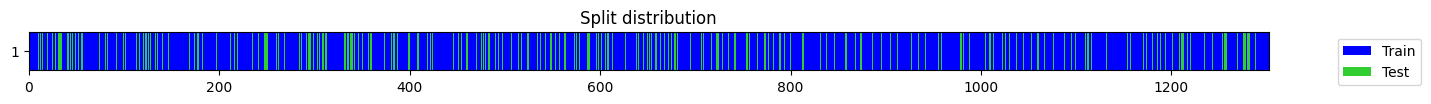

In [17]:
report_splits = get_splits(y, valid_size=0.2, shuffle=True)

In [18]:
X_train, y_train = X[report_splits[0]], y[report_splits[0]]
X_test, y_test = X[report_splits[1]], y[report_splits[1]]

In [19]:
array_gen = ArrayGenerator()
X_train, y_train = array_gen.apply_sliding_window(ts_3d=X_train, labels=y_train, window_size=4096, with_fft=True, overlap_pct=0.8)
X_test, y_test = array_gen.apply_sliding_window(ts_3d=X_test, labels=y_test, window_size=4096, with_fft=True, overlap_pct=0.0)


Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 15, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096

valid == train


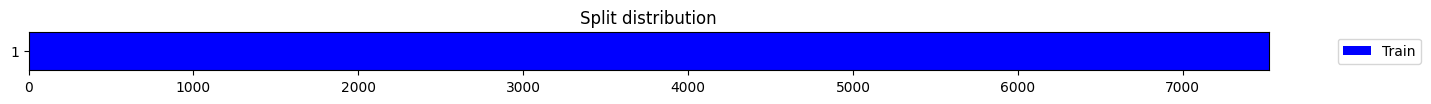

Counter({0: 5945, 1: 5945})

In [20]:
train_balance_splits = get_splits(y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [21]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test]) 

In [22]:
tfms  = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[32,256])

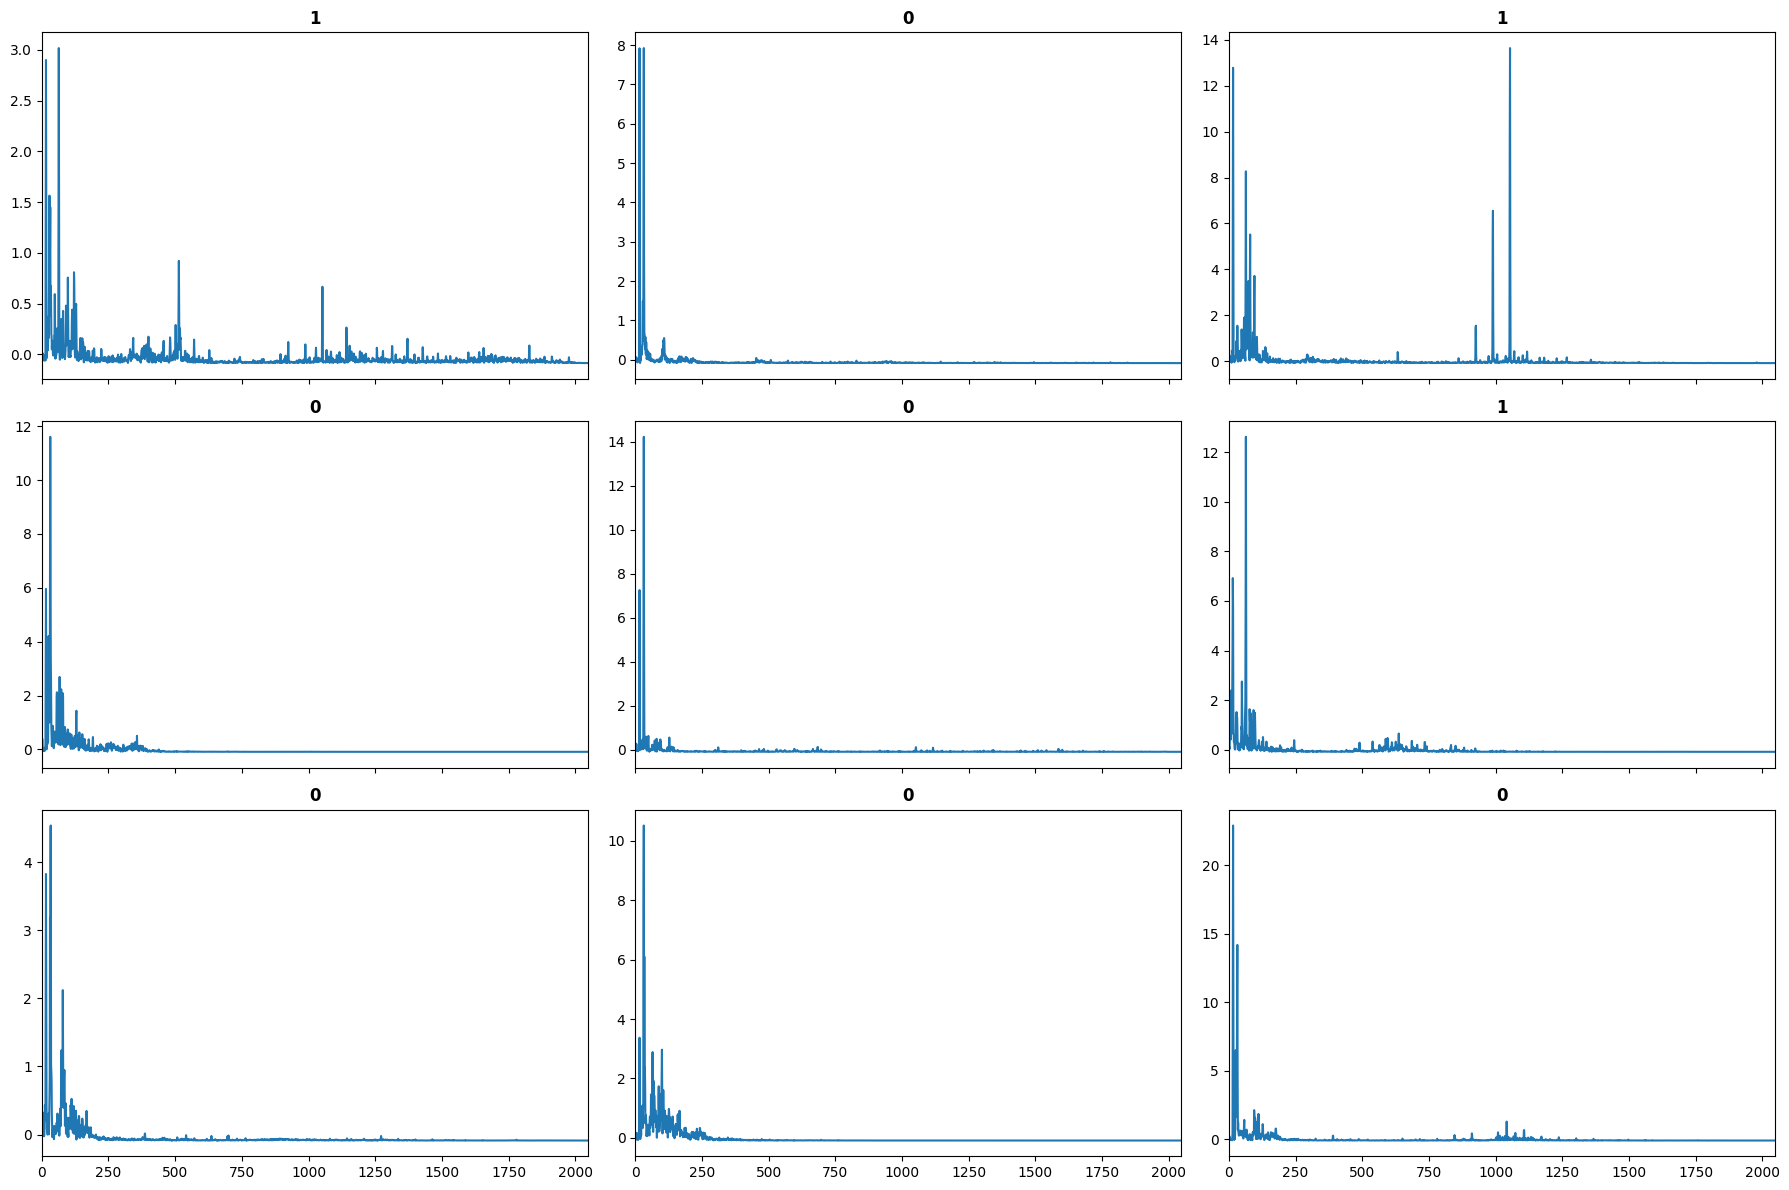

In [23]:
dls.show_batch(sharex=True) 

In [24]:
model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.171460,0.301498,0.872340,0.683168,0.873418,0.766667,0.872709,00:02
1,0.102937,0.236229,0.892097,0.737705,0.854430,0.791789,0.879215,00:02


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
1,0.102937,0.236229,0.892097,0.737705,0.85443,0.791789,0.879215


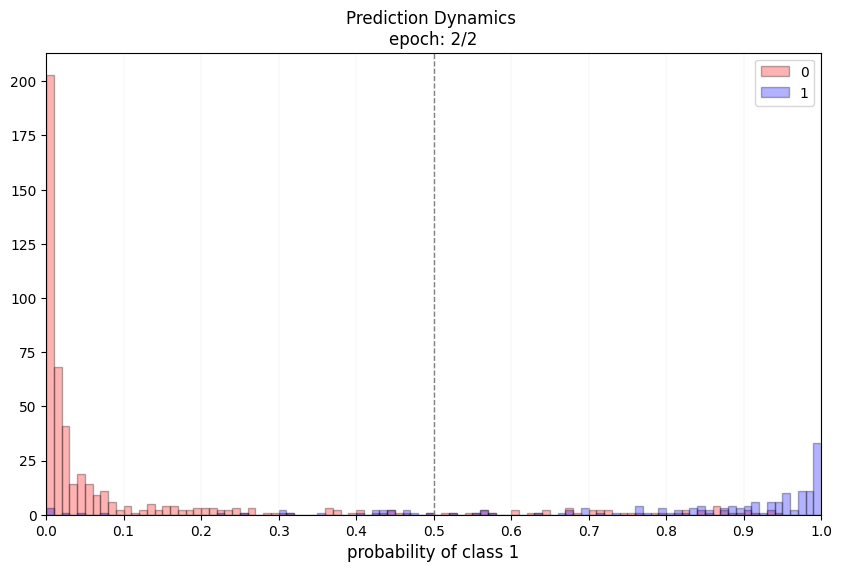

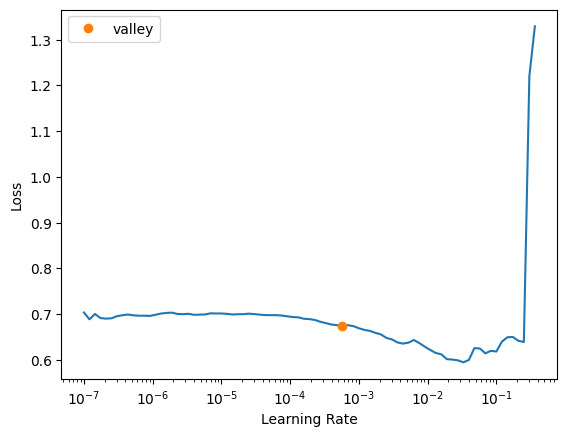

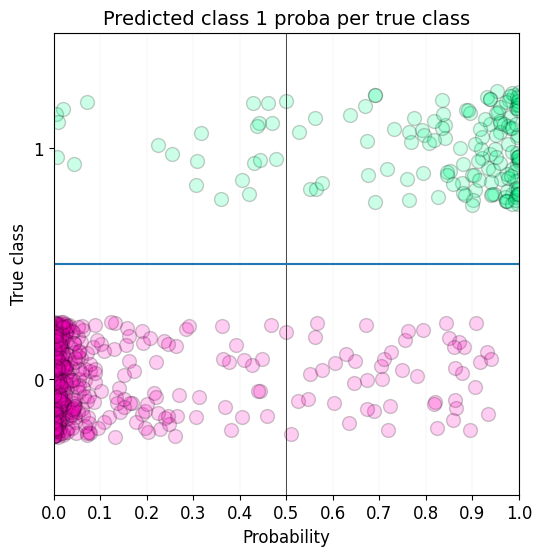

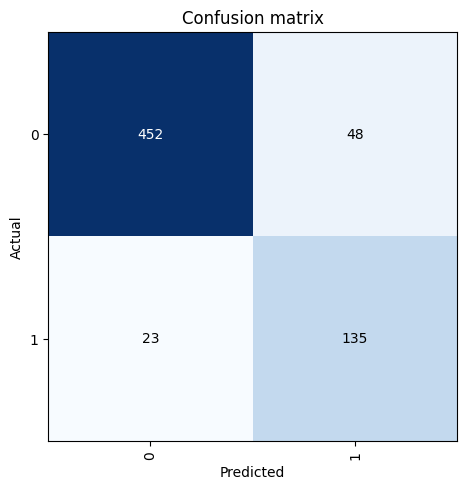

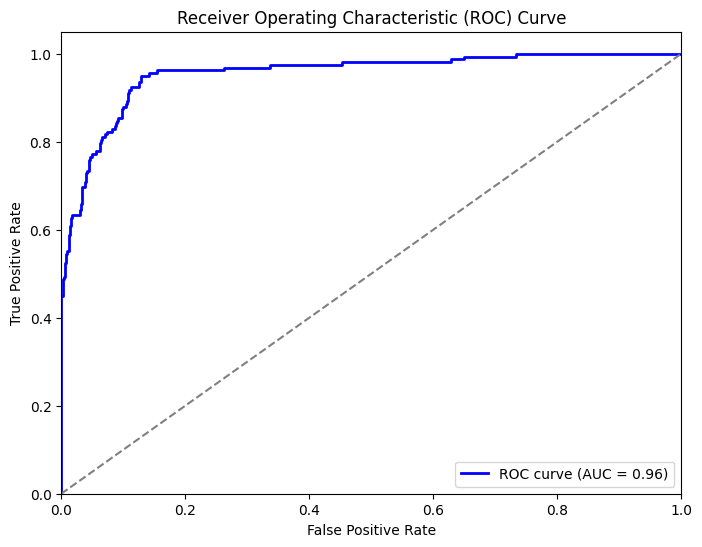

In [25]:
learn.fit_one_cycle(2, lr_max=learn.lr_find(), cbs=[PredictionDynamics()]) 
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
#Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
